## Introduction 

This is the first in a series of two notebooks that explore different sequence aware recommender system methods. In this notebook we will explore a relatively simple baseline method - [Attentive Asynchronous Singular Value Decomposition](https://github.com/microsoft/recommenders). In the following notebook, we will explore a more advanced technique [Short-term and Long-term preference Integrated
Recommender system](https://www.microsoft.com/en-us/research/uploads/prod/2019/07/IJCAI19-ready_v1.pdf) (SLi-Rec). Both methods will be applied to the [Amazon Review Dataset](https://nijianmo.github.io/amazon/index.html). Specifically, the Movies and TV dataset is used which contains 8,765,568 reviews of 203,970 products. 

## Attentive Asymmetric Singular Value Decomposition
Matrix factorization approaches have been widely used to model the long term preferences of users. In the standard setup, user and item latent factors are determined such that there product approximates the ratings matrix. 

<p align="center"> 
<img width="598" alt="Screen Shot 2022-08-03 at 12 47 53 PM" src="https://user-images.githubusercontent.com/34798787/182664416-4ca4ab67-8f76-4c22-aedd-13d326e3161a.png">
</p> 

Early approaches to matrix factoriztion use a singular value decomposition (SVD) to determine the item and latent factors. In practice, the ratings matrix is sparse so the SVD can be ineffective. Instead, stochastic gradient descent is often used to learn user factors $p_i$ and item factors $q_j$ that approximate **observed** ratings $r_{i, j}$ 

$$
\begin{eqnarray}
\min_{p, q} 
\sum_{i, j \in R}{(r_{i, j} - p_i^T q_j)^2 + \lambda(||p_i||^2 + ||q_j||^2)}
\end{eqnarray}
$$

Matrix factorization approaches that avoid explicitly parametizing users have also been proposed. The size of the item set is typically much smaller than the size of the user set so this drastically reduces the amount of parameters. An example of one such approach is the Asymmetric-SVD which represents users as combination of item latent factors $q_j$ weighted by coefficients $a_{k}^{l}$:

$$
\begin{eqnarray}
p_u = \sum_{j \in R} a_{j} q_j
\end{eqnarray}
$$

$a_j$ is the weigting score for behaviour $j$. Thus, it should assign a higher weights to behaviours that are more informative. In the recently proposed [Short-term and Long-term preference Integrated
Recommender system](https://www.microsoft.com/en-us/research/uploads/prod/2019/07/IJCAI19-ready_v1.pdf) (SLi-Rec), $a_j$ is computed as an attention score across items a user has interacted with. The resultant model is reffered to as Attentive Asymmetric Singular Value Decomposition (A2SVD). A2SVD is used in the SLi-Rec to model long term preferences of users. We will explore the SLi-Rec method in the next notebook. However, in this notebook we will be focusing on A2SVD method. 


## Package Imports and Global Variables

In [1]:
# Package Imports
import os
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorboard as tb
import matplotlib.pyplot as plt
from pathlib import Path

from recommenders.utils.timer import Timer
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.io.sequential_iterator import SequentialIterator
from recommenders.models.deeprec.models.sequential.asvd import A2SVDModel
from recommenders.models.deeprec.models.base_model import BaseModel

# Local Imports 
from model import A2SVDModel_Custom as SeqModel
from utils import create_vocab

In [2]:
# DATA_PATH = "/ssd003/projects/aieng/public/recsys_datasets/amazon"
DATA_PATH = Path(f'./Data/kasandr')

BASE_LOG_PATH = "logs"
BASE_MODEL_PATH = "models"
REVIEWS_FILE = 'reviews_Movies_and_TV_5.json'
META_FILE = 'meta_Movies_and_TV.json'

YAML_PATH = "config/asvd.yaml"


EPOCHS = 10
BATCH_SIZE = 400
RANDOM_SEED = 42

train_num_ngs = 4
valid_num_ngs = 4

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Directories to store train, validation and test splits
train_path = os.path.join(DATA_PATH, r'train_data')
valid_path = os.path.join(DATA_PATH, r'valid_data')
test_path = os.path.join(DATA_PATH, r'test_data')

# Files paths to store the list of existing ids for user, item and item category 
user_vocab_path = os.path.join(DATA_PATH, r'user_vocab.pkl')
item_vocab_path = os.path.join(DATA_PATH, r'item_vocab.pkl')
cate_vocab_path = os.path.join(DATA_PATH, r'category_vocab.pkl')
output_file_path = os.path.join(DATA_PATH, r'output.txt')

# File paths to store reviews and associated metadata
reviews_path = os.path.join(DATA_PATH, REVIEWS_FILE)
meta_path = os.path.join(DATA_PATH, META_FILE)

valid_num_ngs = 4 # number of negative instances with a positive instance for validation
test_num_ngs = 9 # number of negative instances with a positive instance for testing

# create run drectory to store results
if os.path.exists(BASE_MODEL_PATH) == False:
    os.mkdir(BASE_MODEL_PATH)
    
MODEL_PATH = f"{BASE_MODEL_PATH}/{str(time.time())}"

if os.path.exists(BASE_LOG_PATH) == False:
    os.mkdir(BASE_LOG_PATH)

LOG_PATH = f"{BASE_LOG_PATH}/{str(time.time())}"

## Data Loading 

Given that the data is preprocessed in the [amazon_preprocessing notebook](amazon_preprocessing.ipynb), no further processing is required. In this section, we will briefly analyze the train, validation and test sets to get aquainted with the data we will be modelling. Futhermore, a data loader will be defined to iteratively fetch samples from the datasets during training and evaluation. 

The train dataset consists of a dataframe where each record is a review of a product `item_id` in category `cate_id` at time `timestamp` by user `user_id`. Each record also contains the list of previous items the user interacted with `prev_ids` along with the corresponding categories `prev_cate_ids` and timestamps `prev_timestamps`.

In [8]:
train_df = pd.read_csv(train_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
train_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867431,cdca1333b6820ab29501f879d8dae7c9,Other,1464807455
1,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867447,"cdca1333b6820ab29501f879d8dae7c9,cdca1333b6820...","Other,Other","1464807455,1464867431"
2,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867528,"cdca1333b6820ab29501f879d8dae7c9,cdca1333b6820...","Other,Other,Other","1464807455,1464867431,1464867447"
3,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867577,"cdca1333b6820ab29501f879d8dae7c9,cdca1333b6820...","Other,Other,Other,Other","1464807455,1464867431,1464867447,1464867528"
4,1,0053b8d4cc3ffb98201781e8d2ac7f668513248f5d5d51...,cdca1333b6820ab29501f879d8dae7c9,Other,1464867922,"cdca1333b6820ab29501f879d8dae7c9,cdca1333b6820...","Other,Other,Other,Other,Other","1464807455,1464867431,1464867447,1464867528,14..."
...,...,...,...,...,...,...,...,...
23822,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,c15ed4a6bcf39c880f56d03fe1aec56a,Other,1464876998,162decae9179e5b628166ffafca22ab1,Other,1464807808
23823,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,75f9aa1430b0e847acb3040e7207784f,Other,1464983603,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other","1464807808,1464876998"
23824,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,0e314aac8bb3e8b47cb665a4a62009d1,Other,1464983618,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other","1464807808,1464876998,1464983603"
23825,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,131c583fddb7f37a3172f01867d8c48d,Other,1465394490,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618"


The validation and test datasets share the schema as the train dataset. The only key distinction is that the evaluations sets contain negative samples which are denoted by a label of 0. Negative samples are interactions between users and items that have not occured. They are included so we can compute metrics of how well the generated recommendations approximate the users actual behaviour. 

In [9]:
# Visualize validation dataset dataframe
valid_df = pd.read_csv(valid_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
valid_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,a5e01c7b865e0ae92bd78ad6db1d1576,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
1,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,5a6a0ad75329c2721d7273cf8cbb7b63,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
2,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,d1b4365db02dd693661e0186dbfcc2e7,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
3,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,7b77553a80a31ccf5d0fe2a387748575,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
4,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,0f2fcf95319f5c1e5745371351f521e5,Other,1464943154,b203435e0ca71f90508403e762d3a42f,Other,1464850748
...,...,...,...,...,...,...,...,...
12065,1,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,d37111749fe898b02f86688363a4598b,Other,1465397402,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
12066,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,0fc06555404935b0bc18407da4c143b5,Other,1465397402,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
12067,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,a5fc37404646ac3d34118489cdbfb341,Other,1465397402,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
12068,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,eb0389774fca117ee06c5c02a6ba76af,Other,1465397402,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."


In [10]:
# Visualize test dataset dataframe
test_df = pd.read_csv(test_path, sep="\t", index_col=False, names=["label", "user_id", "item_id", "cate_id", "timestamp", "prev_item_ids", "prev_cate_ids", "prev_timestamps"])
test_df

,label,user_id,item_id,cate_id,timestamp,prev_item_ids,prev_cate_ids,prev_timestamps
0,1,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,bf0ddbcb5fcb316d0a2f6f3655b27b91,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
1,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,5a6a0ad75329c2721d7273cf8cbb7b63,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
2,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,de5795e6274c9538b6afe3d98112611d,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
3,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,e9d41bf5aeba0591ef080d3513375338,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
4,0,0051becd5b9fed9a79ffa923e256e28f3eeadd80206cee...,eb0389774fca117ee06c5c02a6ba76af,Other,1464943300,"b203435e0ca71f90508403e762d3a42f,a5e01c7b865e0...","Other,Other","1464850748,1464943154"
...,...,...,...,...,...,...,...,...
28125,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,0f2fcf95319f5c1e5745371351f521e5,Other,1465626127,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
28126,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,04ab0460f36b12d22fd4321eaa9b39cb,Other,1465626127,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
28127,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,162decae9179e5b628166ffafca22ab1,Other,1465626127,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."
28128,0,fffea4925ff656615c4e6b690cf1cce459237f36b64de3...,2a21cb8865da59cc4845d822c6923ada,Other,1465626127,"162decae9179e5b628166ffafca22ab1,c15ed4a6bcf39...","Other,Other,Other,Other,Other,Other,Other","1464807808,1464876998,1464983603,1464983618,14..."


When training and evaluating neural network models, we typically feed batches of input into the model to generate predictions. This involves iterively sampling batches of data in the dataset . The [microsoft recommenders](https://github.com/microsoft/recommenders) package provides the `SequentialIterator` class which acts as a dataloader for recommender systems. 

In [11]:
input_creator = SequentialIterator

Following the definition of the Sequential Dataset, we need to generate the user, item and category files using the `utils.create_vocab` function. These files contain the unique ids of each user, item and category in the dataset, respectively. This is leveraged by the model to generate embedding tables of the proper dimension. 

In [12]:
create_vocab(train_path, user_vocab_path, item_vocab_path, cate_vocab_path)

## Model Definition

With the sequential dataset in place, we can turn our attention to defining the A2SVDModel model. The [microsoft recommenders](https://github.com/microsoft/recommenders) package provides a variety of recommender methods including A2SVDModel. It provides a uniform interface for both sequential and non-sequential recommender system methods. 

The first step to defining a model is generating the hyperameters `hparams` using the `recommenders.models.deeprec.deeprec_utils.prepare_hparams` function. This function takes a varitey of arguments including model, log save paths and vocabulary file paths along with hyperparameters such as batch size and epochs. The majority of hyperparameters are started in a yaml path at `YAML_PATH`. The microsoft recommenders package provides a [yaml file](https://github.com/microsoft/recommenders/tree/main/recommenders/models/deeprec/config) with default hyperparameters for each of the sequential architectures it supports. 

Some of the notable hyperparameters include: 
- **batch_size**:  The number of samples per batch
- **epochs**: The number of times to iterate through the training set
- **embed_l2**: The weight of the l2 regularization loss on embeddings
- **layer_l2**: The weight of the l2 regularization loss on layer weights
- **train_num_ngs**: The number of negative instances to include per postive instance in training set 
- **learning_rate**: Determines the step size of updates to model parameters

In [51]:
hparams = prepare_hparams(YAML_PATH, 
                          embed_l2=0., 
                          layer_l2=0., 
                          learning_rate=0.001,  # set to 0.01 if batch normalization is disable
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          metrics=['auc'] ,
                          pairwise_metrics=['ndcg@1;3;5','hit@1;3;5', "group_auc"],
                          show_step=20,
                          MODEL_DIR=os.path.join(MODEL_PATH),
                          SUMMARIES_DIR=os.path.join(LOG_PATH),
                          user_vocab=user_vocab_path,
                          item_vocab=item_vocab_path,
                          cate_vocab=cate_vocab_path,
                          need_sample=True,
                          train_num_ngs=train_num_ngs, # provides the number of negative instances for each positive instance for loss computation.
            )

To define the model, we pass the hyperparameters, sequential dataset and seed to the `models.A2SVDModel_Custom` constructor. The `models.SLI_RECModel_Custom` class is a simple extension of the `recommenders.models.deeprec.models.sequential.asvd.A2SVDModel` that overrides the `fit` method to more easily access train and evaluation metrics accross epochs. This is done as a convenience and is by no means required by package. 

In [52]:
model = SeqModel(hparams, input_creator, seed=RANDOM_SEED)

## Training and Validation

The next step is to train and validated the model we defined using the training and validation set we previously generated using the `model.fit` method. This method trains and validates the model for a number of epochs and returns the updated model along with the train and validation results. 

In [53]:
with Timer() as train_time:
    model, train_info, eval_info = model.fit(train_path, valid_path, valid_num_ngs=valid_num_ngs) 

# valid_num_ngs is the number of negative lines after each positive line in your valid_file 
# we will evaluate the performance of model on valid_file every epoch
print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))

step 20 , total_loss: 1.2841, data_loss: 1.2841
step 40 , total_loss: 1.0878, data_loss: 1.0878
step 60 , total_loss: 1.0894, data_loss: 1.0894
eval valid at epoch 1: auc:0.5253,ndcg@1:0.1773,ndcg@3:0.458,ndcg@5:0.5911,hit@1:0.1773,hit@3:0.6806,hit@5:1.0,group_auc:0.539
INFO:tensorflow:models/1675335536.3683693epoch_10.meta


INFO:tensorflow:models/1675335536.3683693epoch_10.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693epoch_1.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693epoch_1.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


INFO:tensorflow:models/1675335536.3683693epoch_1.meta


INFO:tensorflow:models/1675335536.3683693epoch_1.meta


INFO:tensorflow:1300


INFO:tensorflow:1300


INFO:tensorflow:models/1675335536.3683693epoch_1.index


INFO:tensorflow:models/1675335536.3683693epoch_1.index


INFO:tensorflow:1300


INFO:tensorflow:1300


INFO:tensorflow:models/1675335536.3683693epoch_10.index


INFO:tensorflow:models/1675335536.3683693epoch_10.index


INFO:tensorflow:1300


INFO:tensorflow:1300


INFO:tensorflow:models/1675335536.3683693epoch_10.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693epoch_10.data-00000-of-00001


INFO:tensorflow:1600


INFO:tensorflow:1600


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


step 20 , total_loss: 0.9857, data_loss: 0.9857
step 40 , total_loss: 0.8669, data_loss: 0.8669
step 60 , total_loss: 0.9170, data_loss: 0.9170
eval valid at epoch 2: auc:0.71,ndcg@1:0.3592,ndcg@3:0.6371,ndcg@5:0.7025,hit@1:0.3592,hit@3:0.8438,hit@5:1.0,group_auc:0.698
INFO:tensorflow:models/1675335536.3683693epoch_2.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693epoch_2.data-00000-of-00001


INFO:tensorflow:300


INFO:tensorflow:300


INFO:tensorflow:models/1675335536.3683693epoch_2.index


INFO:tensorflow:models/1675335536.3683693epoch_2.index


INFO:tensorflow:300


INFO:tensorflow:300


INFO:tensorflow:models/1675335536.3683693epoch_2.meta


INFO:tensorflow:models/1675335536.3683693epoch_2.meta


INFO:tensorflow:800


INFO:tensorflow:800


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


step 20 , total_loss: 0.6259, data_loss: 0.6259
step 40 , total_loss: 0.5580, data_loss: 0.5580
step 60 , total_loss: 0.5042, data_loss: 0.5042
eval valid at epoch 3: auc:0.9329,ndcg@1:0.8161,ndcg@3:0.9245,ndcg@5:0.927,hit@1:0.8161,hit@3:0.9938,hit@5:1.0,group_auc:0.9435
INFO:tensorflow:models/1675335536.3683693epoch_3.index


INFO:tensorflow:models/1675335536.3683693epoch_3.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675335536.3683693epoch_3.meta


INFO:tensorflow:models/1675335536.3683693epoch_3.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693epoch_3.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693epoch_3.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


step 20 , total_loss: 0.4517, data_loss: 0.4517
step 40 , total_loss: 0.3992, data_loss: 0.3992
step 60 , total_loss: 0.3263, data_loss: 0.3263
eval valid at epoch 4: auc:0.9521,ndcg@1:0.8364,ndcg@3:0.9328,ndcg@5:0.9351,hit@1:0.8364,hit@3:0.9946,hit@5:1.0,group_auc:0.95
INFO:tensorflow:models/1675335536.3683693epoch_4.meta


INFO:tensorflow:models/1675335536.3683693epoch_4.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693epoch_4.index


INFO:tensorflow:models/1675335536.3683693epoch_4.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693epoch_4.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693epoch_4.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


step 20 , total_loss: 0.3915, data_loss: 0.3915
step 40 , total_loss: 0.3496, data_loss: 0.3496
step 60 , total_loss: 0.3737, data_loss: 0.3737
eval valid at epoch 5: auc:0.9545,ndcg@1:0.8509,ndcg@3:0.9372,ndcg@5:0.9401,hit@1:0.8509,hit@3:0.993,hit@5:1.0,group_auc:0.9528
INFO:tensorflow:models/1675335536.3683693epoch_5.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693epoch_5.data-00000-of-00001


INFO:tensorflow:300


INFO:tensorflow:300


INFO:tensorflow:models/1675335536.3683693epoch_5.index


INFO:tensorflow:models/1675335536.3683693epoch_5.index


INFO:tensorflow:300


INFO:tensorflow:300


INFO:tensorflow:models/1675335536.3683693epoch_5.meta


INFO:tensorflow:models/1675335536.3683693epoch_5.meta


INFO:tensorflow:800


INFO:tensorflow:800


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


step 20 , total_loss: 0.3575, data_loss: 0.3575
step 40 , total_loss: 0.3058, data_loss: 0.3058
step 60 , total_loss: 0.3623, data_loss: 0.3623
eval valid at epoch 6: auc:0.9539,ndcg@1:0.8434,ndcg@3:0.9352,ndcg@5:0.9381,hit@1:0.8434,hit@3:0.993,hit@5:1.0,group_auc:0.9522
step 20 , total_loss: 0.3406, data_loss: 0.3406
step 40 , total_loss: 0.3750, data_loss: 0.3750
step 60 , total_loss: 0.3831, data_loss: 0.3831
eval valid at epoch 7: auc:0.9615,ndcg@1:0.8492,ndcg@3:0.9391,ndcg@5:0.9406,hit@1:0.8492,hit@3:0.9963,hit@5:1.0,group_auc:0.9547
INFO:tensorflow:models/1675335536.3683693epoch_7.index


INFO:tensorflow:models/1675335536.3683693epoch_7.index


INFO:tensorflow:0


INFO:tensorflow:0


INFO:tensorflow:models/1675335536.3683693epoch_7.meta


INFO:tensorflow:models/1675335536.3683693epoch_7.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693epoch_7.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693epoch_7.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


step 20 , total_loss: 0.3057, data_loss: 0.3057
step 40 , total_loss: 0.3162, data_loss: 0.3162
step 60 , total_loss: 0.3039, data_loss: 0.3039
eval valid at epoch 8: auc:0.9632,ndcg@1:0.848,ndcg@3:0.9383,ndcg@5:0.9402,hit@1:0.848,hit@3:0.9954,hit@5:1.0,group_auc:0.9545
step 20 , total_loss: 0.2897, data_loss: 0.2897
step 40 , total_loss: 0.3142, data_loss: 0.3142
step 60 , total_loss: 0.2756, data_loss: 0.2756
eval valid at epoch 9: auc:0.9646,ndcg@1:0.8488,ndcg@3:0.9376,ndcg@5:0.9403,hit@1:0.8488,hit@3:0.9934,hit@5:1.0,group_auc:0.9538
step 20 , total_loss: 0.3387, data_loss: 0.3387
step 40 , total_loss: 0.3234, data_loss: 0.3234
step 60 , total_loss: 0.3617, data_loss: 0.3617
eval valid at epoch 10: auc:0.9634,ndcg@1:0.8496,ndcg@3:0.9394,ndcg@5:0.9412,hit@1:0.8496,hit@3:0.9959,hit@5:1.0,group_auc:0.9556
INFO:tensorflow:models/1675335536.3683693epoch_10.meta


INFO:tensorflow:models/1675335536.3683693epoch_10.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693epoch_10.index


INFO:tensorflow:models/1675335536.3683693epoch_10.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693epoch_10.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693epoch_10.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:models/1675335536.3683693/best_model.meta


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:models/1675335536.3683693/best_model.index


INFO:tensorflow:500


INFO:tensorflow:500


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:models/1675335536.3683693/best_model.data-00000-of-00001


INFO:tensorflow:800


INFO:tensorflow:800


[(1, {'auc': 0.5253, 'ndcg@1': 0.1773, 'ndcg@3': 0.458, 'ndcg@5': 0.5911, 'hit@1': 0.1773, 'hit@3': 0.6806, 'hit@5': 1.0, 'group_auc': 0.539}), (2, {'auc': 0.71, 'ndcg@1': 0.3592, 'ndcg@3': 0.6371, 'ndcg@5': 0.7025, 'hit@1': 0.3592, 'hit@3': 0.8438, 'hit@5': 1.0, 'group_auc': 0.698}), (3, {'auc': 0.9329, 'ndcg@1': 0.8161, 'ndcg@3': 0.9245, 'ndcg@5': 0.927, 'hit@1': 0.8161, 'hit@3': 0.9938, 'hit@5': 1.0, 'group_auc': 0.9435}), (4, {'auc': 0.9521, 'ndcg@1': 0.8364, 'ndcg@3': 0.9328, 'ndcg@5': 0.9351, 'hit@1': 0.8364, 'hit@3': 0.9946, 'hit@5': 1.0, 'group_auc': 0.95}), (5, {'auc': 0.9545, 'ndcg@1': 0.8509, 'ndcg@3': 0.9372, 'ndcg@5': 0.9401, 'hit@1': 0.8509, 'hit@3': 0.993, 'hit@5': 1.0, 'group_auc': 0.9528}), (6, {'auc': 0.9539, 'ndcg@1': 0.8434, 'ndcg@3': 0.9352, 'ndcg@5': 0.9381, 'hit@1': 0.8434, 'hit@3': 0.993, 'hit@5': 1.0, 'group_auc': 0.9522}), (7, {'auc': 0.9615, 'ndcg@1': 0.8492, 'ndcg@3': 0.9391, 'ndcg@5': 0.9406, 'hit@1': 0.8492, 'hit@3': 0.9963, 'hit@5': 1.0, 'group_auc': 0.95

In [54]:
# unpack train and evaluation info
epochs, train_metrics = zip(*train_info)
epochs, eval_metrics = zip(*eval_info)

# Reformat train metrics from list of dicts to dict of lists 
train_column_names = train_metrics[0].keys()
train_metric_dict = {name: [] for name in train_column_names}
for train_metric in train_metrics: 
    for key, val in train_metric.items():
        train_metric_dict[key].append(val)

# Reformat eval metrics from list of dicts to dict of lists 
eval_column_names = eval_metrics[0].keys()
eval_metric_dict = {name: [] for name in eval_column_names}
for eval_metric in eval_metrics:
    for key, val in eval_metric.items():
        eval_metric_dict[key].append(val) 

The train metrics that are logged include: 
- **Loss**: The loss is the summation of the regularization loss and the data loss. The regularization loss penalizes the magnitude of the parameters to avoid overfitting.
- **Data Loss:** The data loss is computed between the rating predicted by the model and the ground truth interactions. This is typically a cross entropy loss for data with implicit feedback and mean squared error loss for explicit feedback.

We can visualize plot these metrics across metrics as follows: 

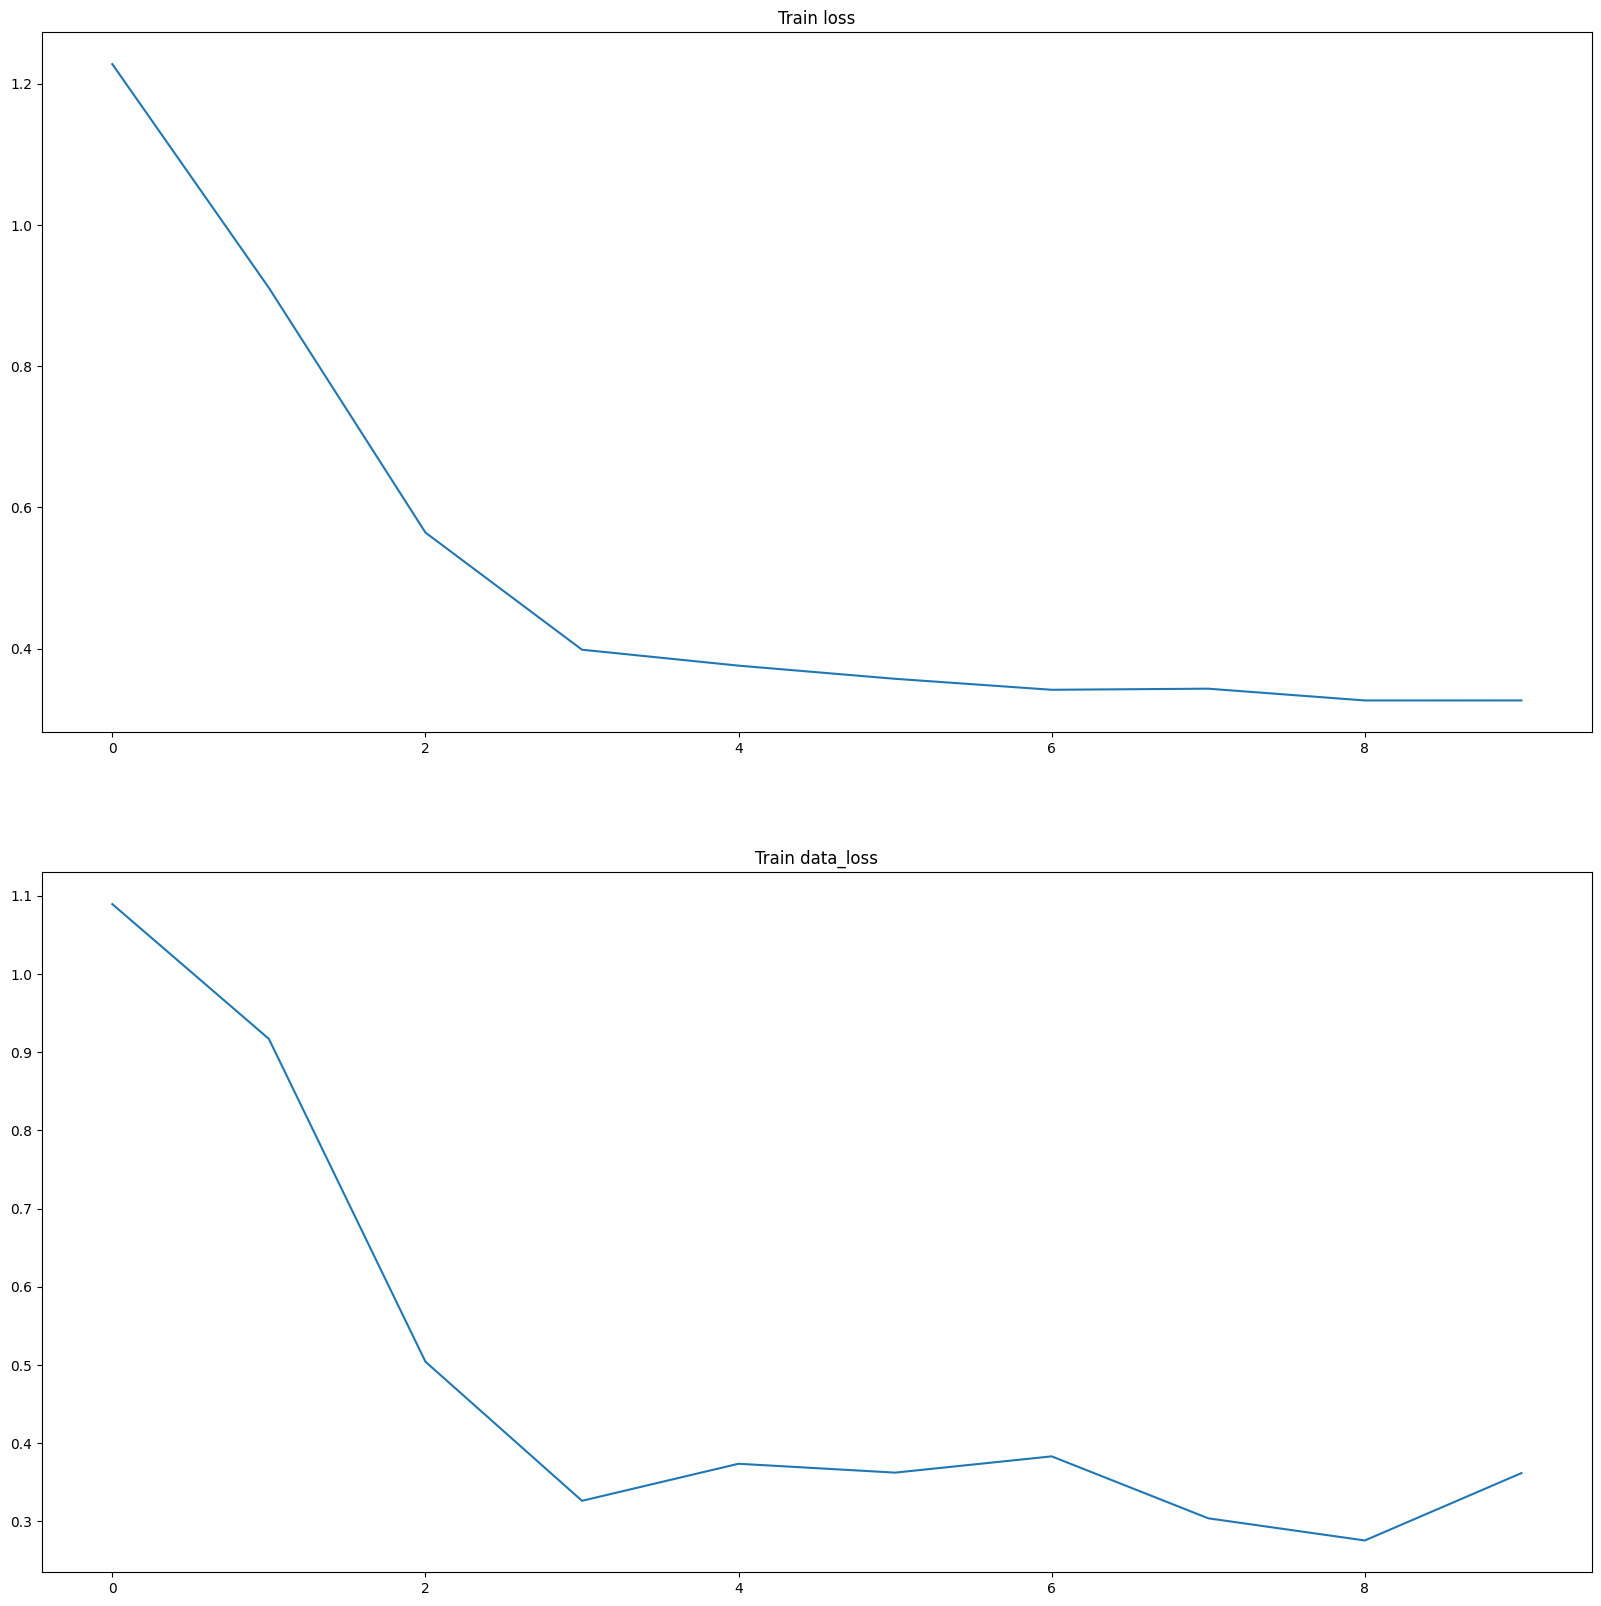

In [55]:
# Visualize train metrics

f, axarr = plt.subplots(len(train_metric_dict.keys()), 1, figsize=(20, 20))

for i, key in enumerate(train_metric_dict.keys()): 
    index = list(range(len(train_metric_dict[key])))
    vals = train_metric_dict[key]
    axarr[i].set_title(f"Train {key}")
    axarr[i].plot(index, vals)

The validation metrics that are logged include: 
- **AUC**: [AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=AUC%20stands%20for%20%22Area%20under,to%20(1%2C1)) measures the likelihood that a random relevant item is ranked higher than a random irrelevant item. Higher the likelihood of this happening implies a higher AUC score meaning a better recommendation system. 
- **GROUP AUC**: Average AUC across users.
- **Normalized discounted cumulative gain (NDCG@K)**: NDCG measures the overall reward at all positions that hold a relevant item. The reward is an inverse log of the position (i.e. higher ranks for relevant items would lead to better reward, as desired).

For more information regarding the aforementioned metrics, please refer to this [blog post](https://flowthytensor.medium.com/some-metrics-to-evaluate-recommendation-systems-9e0cf0c8b6cf#:~:text=AUC%20measures%20the%20likelihood%20that,meaning%20a%20better%20recommendation%20system.). 

We can visualize plot these metrics across metrics as follows:

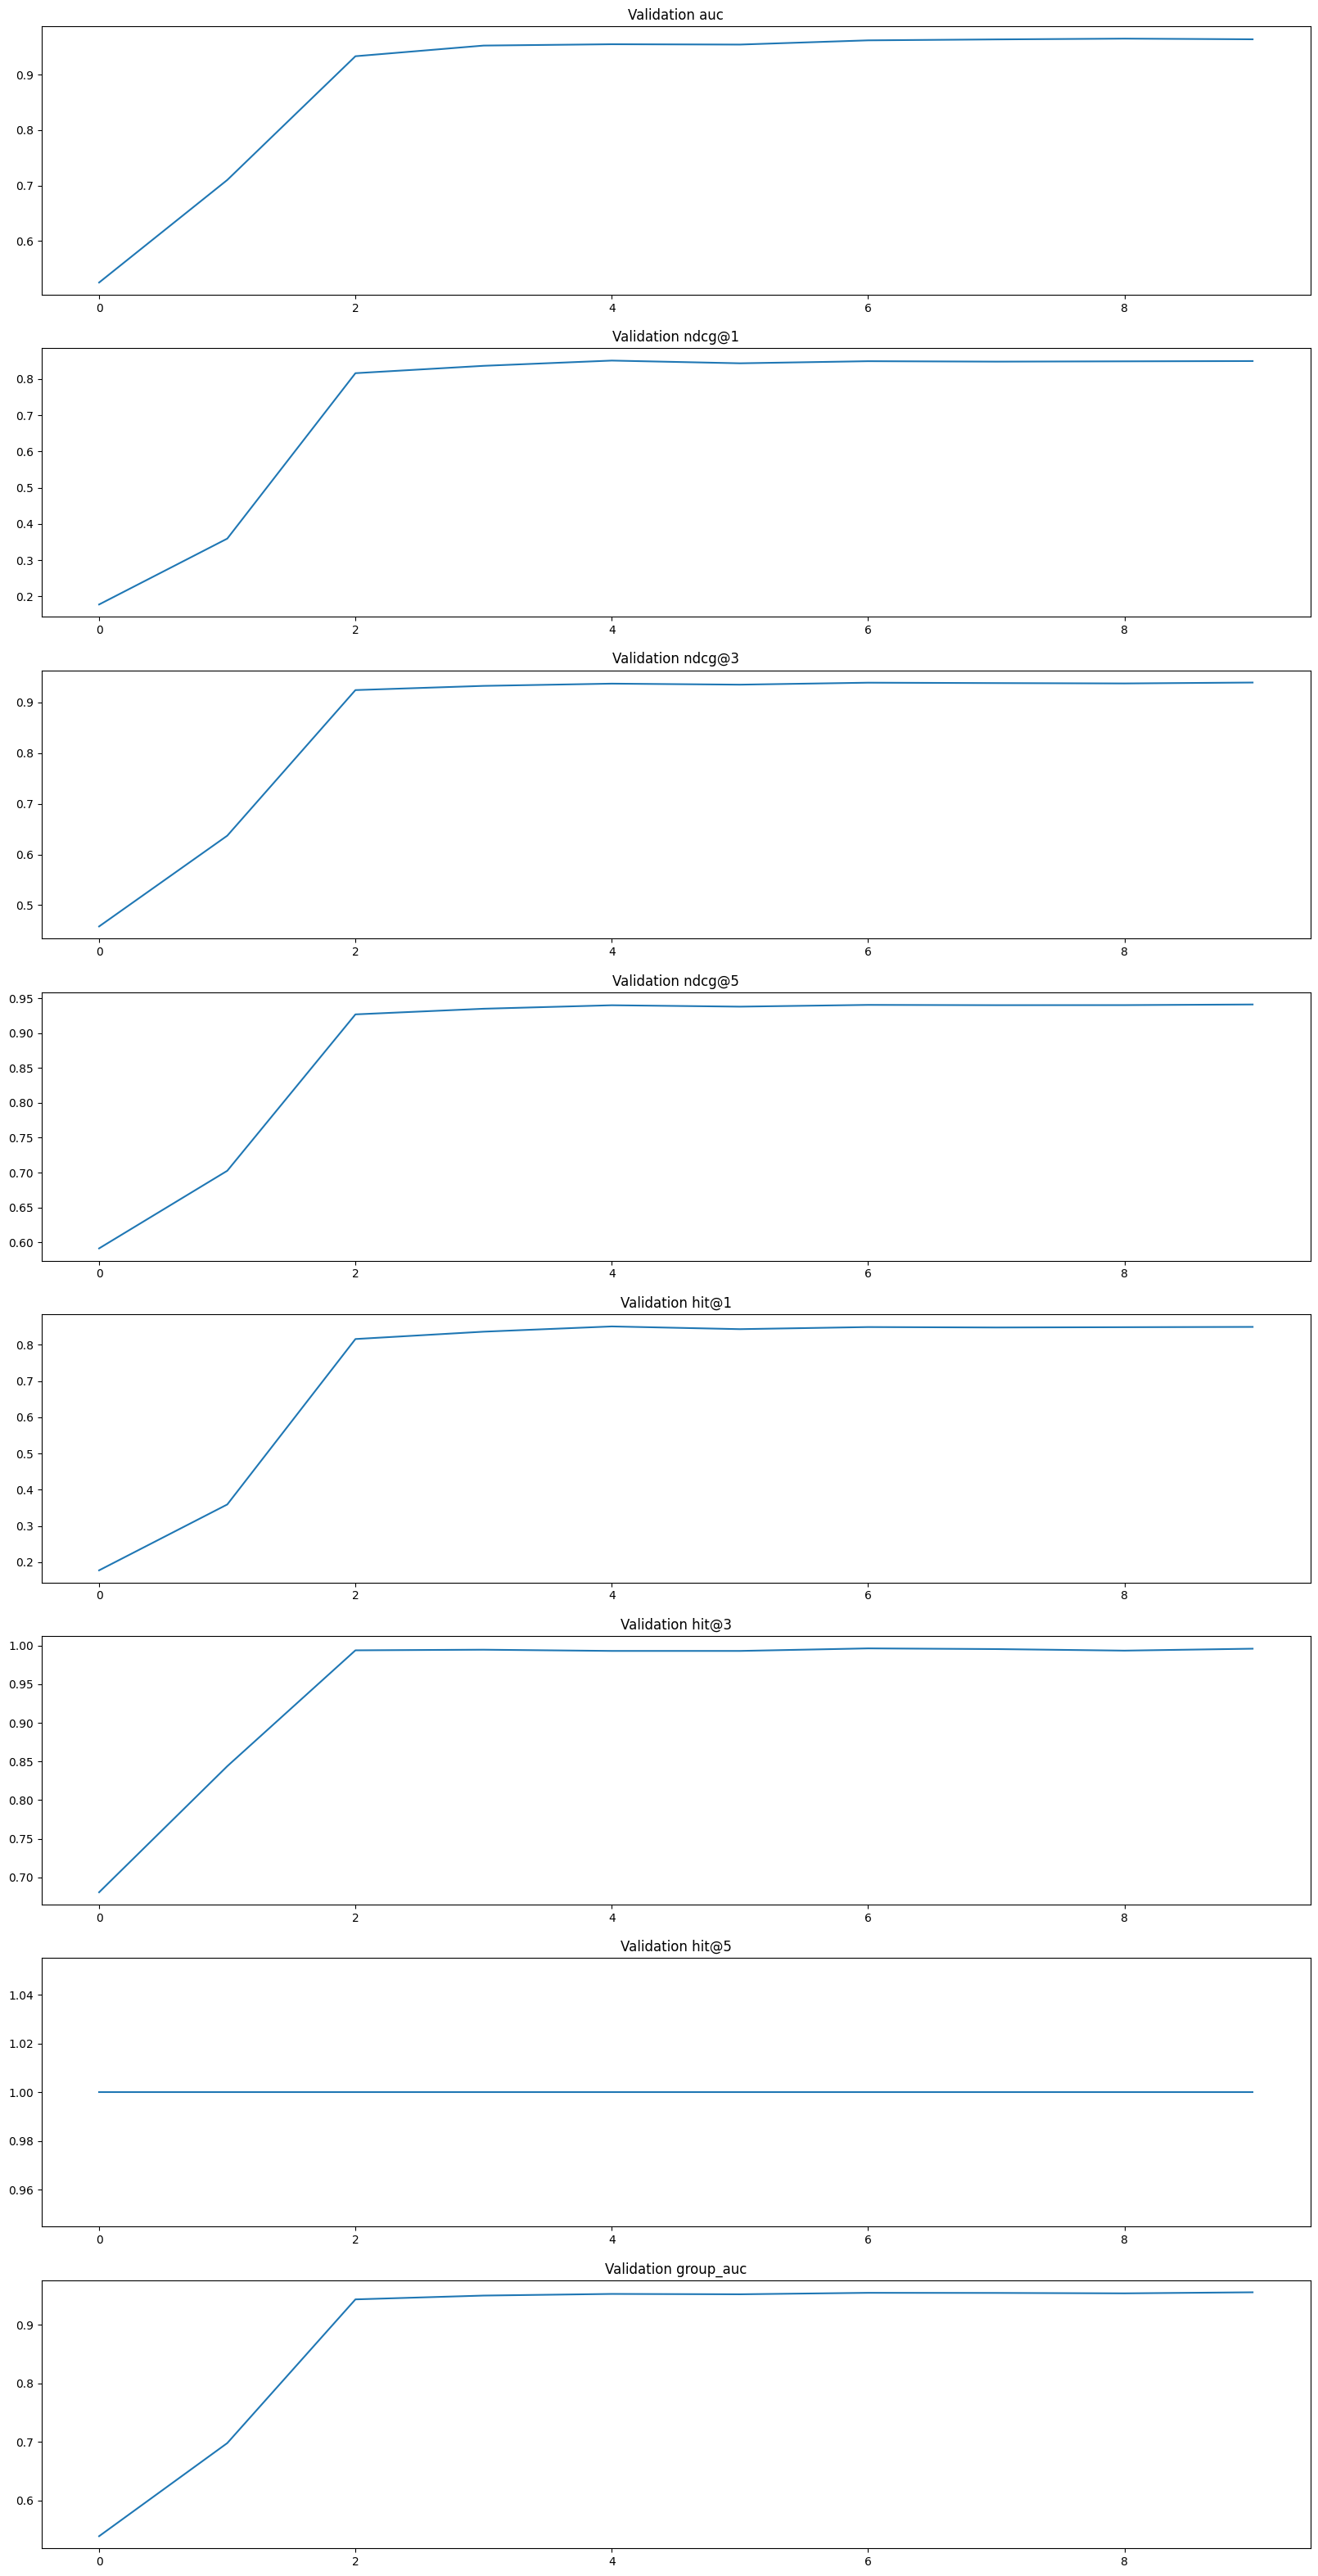

In [56]:
# Visualize eval metrics

f, axarr = plt.subplots(len(eval_metric_dict.keys()), 1, figsize=(20, 40))

for i, key in enumerate(eval_metric_dict.keys()): 
    index = list(range(len(eval_metric_dict[key])))
    vals = eval_metric_dict[key]
    axarr[i].set_title(f"Validation {key}")
    axarr[i].plot(index, vals)

## Testing

In [57]:
res = model.run_eval(test_path, num_ngs=test_num_ngs)
print(res)

{'auc': 0.9512, 'ndcg@1': 0.7017, 'ndcg@3': 0.8461, 'ndcg@5': 0.8608, 'hit@1': 0.7017, 'hit@3': 0.9442, 'hit@5': 0.9794, 'group_auc': 0.9385}


In [58]:
res["name"] = "A2SVD"
res = {key: [val] for key, val in res.items()}
res_df = pd.DataFrame.from_dict(res)
res_df

,auc,ndcg@1,ndcg@3,ndcg@5,hit@1,hit@3,hit@5,group_auc,name
0,0.9512,0.7017,0.8461,0.8608,0.7017,0.9442,0.9794,0.9385,A2SVD


In [59]:
res_df.to_csv("kasandr_results.csv", index=False)